In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (11., 7.)

For $\gamma$, medical sources state that the average COVID case lasts about 14 days, which would give us an estimate of $\gamma = \frac{1}{14} = 0.07$. However, some cases can last several weeks. According to the second blog post, $\gamma$ ranges from $0.03-0.06$.

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
data = pd.read_csv(url)
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,154283,154361,154487,154487,154487,154585,154712,154757,154800,154960
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,159423,160365,161324,162173,162953,163404,164276,165096,165864,166690
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,200770,200989,201224,201425,201600,201766,201948,202122,202283,202449
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15108,15113,15124,15124,15124,15140,15140,15153,15156,15167
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,51407,51827,52208,52307,52307,52644,52968,53387,53840,54280


# Fitting US Data

Here, we're estimating $\beta$ using data from the United States.

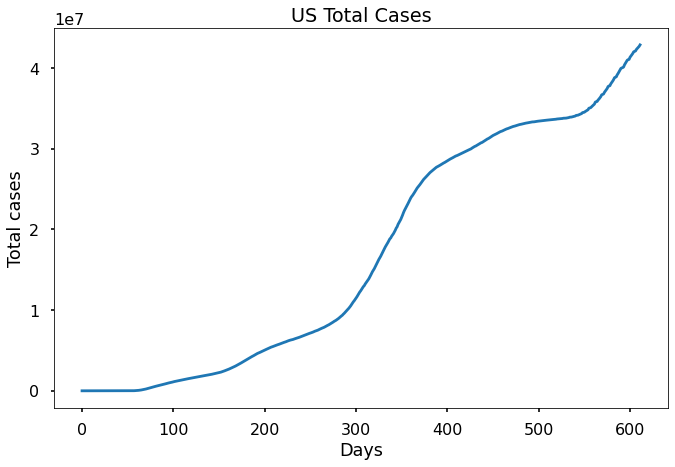

In [23]:
days = data.keys()[4:]
us_data = extract_region_data(data, 'US')
plt.plot(us_data)
plt.title('US Total Cases')
plt.xlabel('Days')
plt.ylabel('Total cases');

We start from day 50ish since the US doesn't have any reported cases until about March, so it doesn't really make sense to include days whose values are zero in our estimate for $\beta$. We're also not using the whole dataset for our estimate. The outbreak seems to be pretty steady and constant for the first 80 days or so from when it started. These choices were completely arbitrary.

Text(0.5, 1.0, 'United States')

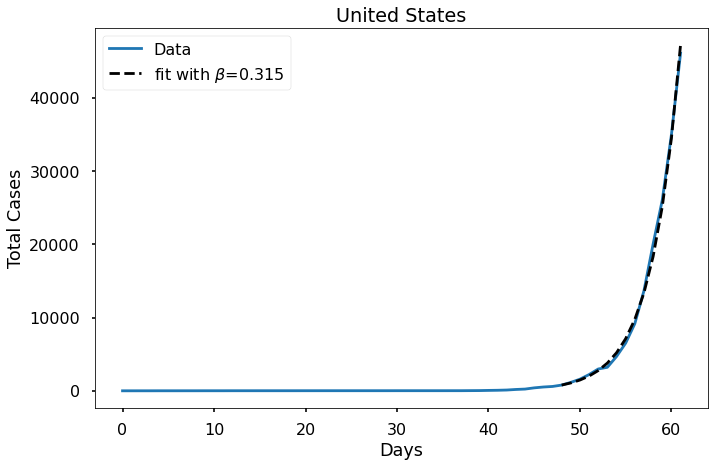

In [31]:
dd = np.arange(len(days))
beta = exponential_beta_fit(us_data, 48)
plot_fit(us_data, beta, start=48)
plt.title('United States')

The above fit seems reasonable. But, how would the prediction fair over the next 20 days? 

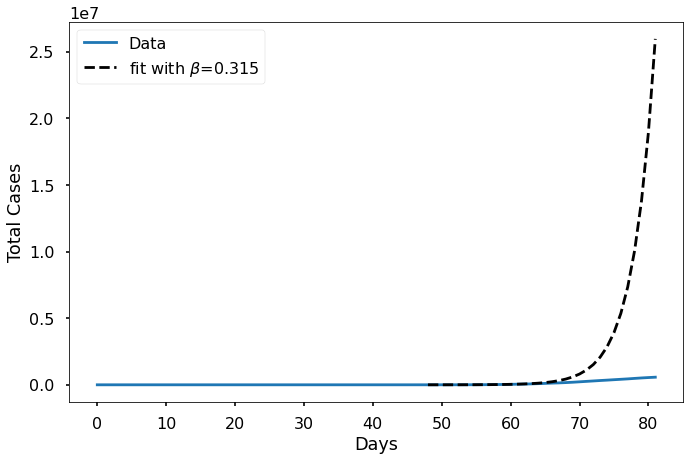

In [35]:
plot_fit(us_data, beta, start=48, n=34)

Well, it looks like the prediction isn't very accurate after about a month or so. This is because our assumption that the disease spreads at an exponential rate is only really valid at the start of the outbreak. Additionally, society took measures to try and minimize $\beta$ at the start (after about 7 months though, the US sort of stopped caring).

# Spain Data

(0.0, 500000.0)

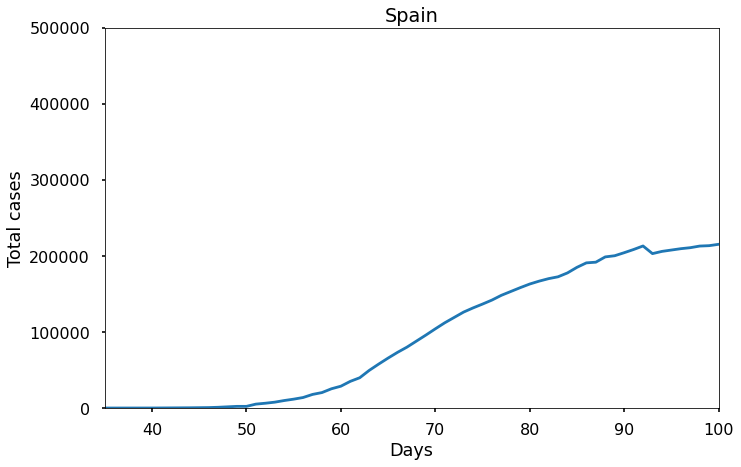

In [42]:
spain_data = extract_region_data(data, 'Spain')
plt.plot(spain_data)
plt.title('Spain')
plt.xlabel('Days')
plt.ylabel('Total cases');
plt.xlim([35, 100])
plt.ylim([0, 500000])

Text(0.5, 1.0, 'Spain')

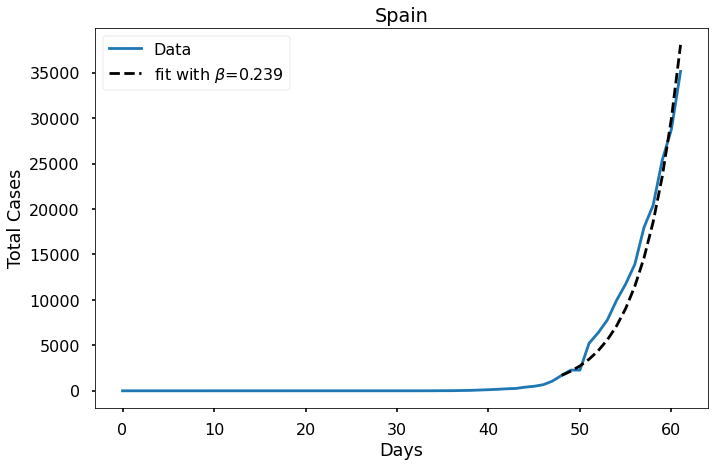

In [43]:
beta = exponential_beta_fit(spain_data, 48)
plot_fit(spain_data, beta, start=48)
plt.title('Spain')

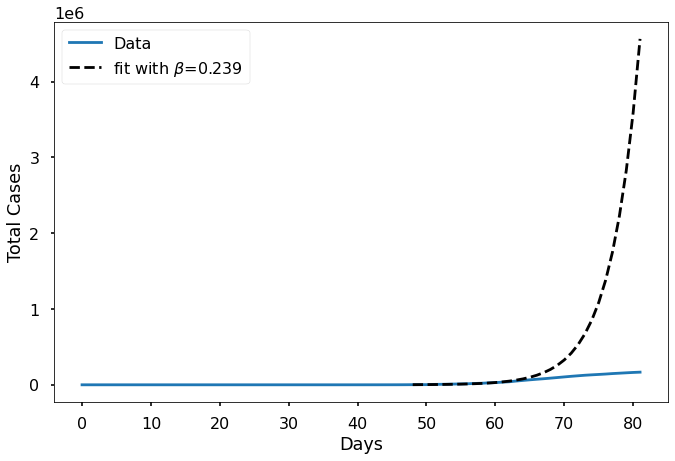

In [44]:
plot_fit(spain_data, beta, start=48, n=34)

# New Zealand

(0.0, 110.0)

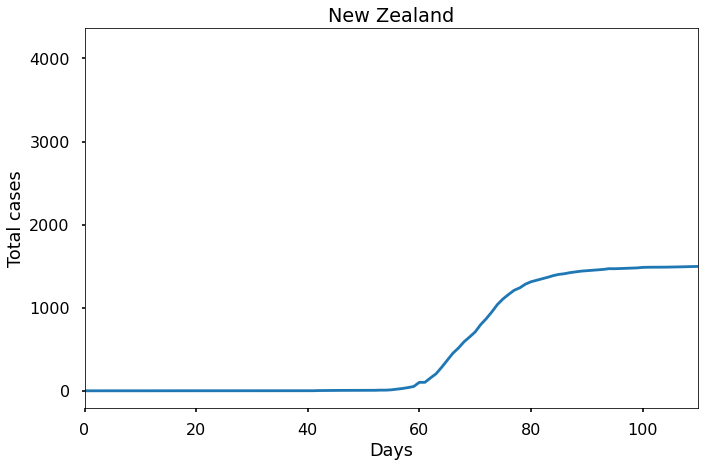

In [46]:
zealand_data = extract_region_data(data, 'New Zealand')
plt.plot(zealand_data)
plt.title('New Zealand')
plt.xlabel('Days')
plt.ylabel('Total cases');
plt.xlim([0, 110])

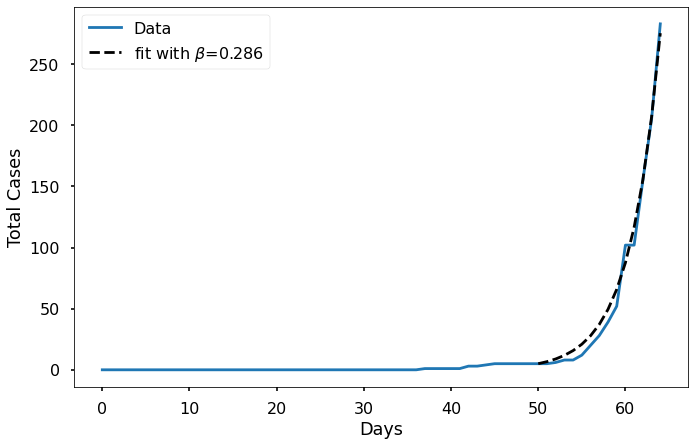

In [58]:
beta = exponential_beta_fit(zealand_data, 50, n=15)
plot_fit(zealand_data, beta, start=50, n=15)

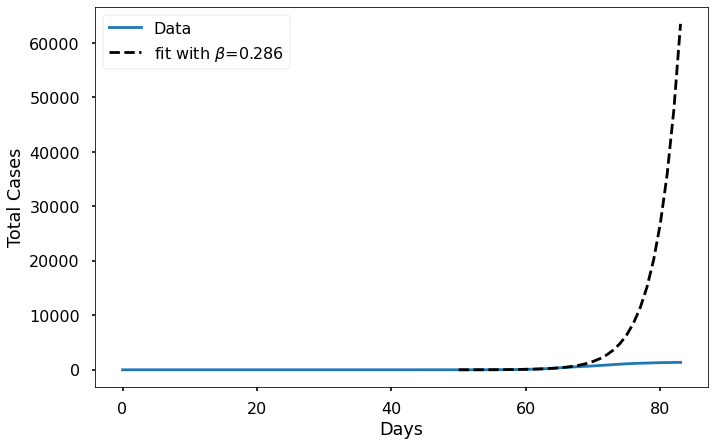

In [59]:
plot_fit(zealand_data, beta, start=50, n=34)

One thing to note here, is that much like South Korea (from blog post 2), New Zealand has drastically reduced the value of $\beta$. This is because when New Zealand was first struck by COVID, the country responded by going into full lock down for roughly 2-3 months (from end of February to mid May). Social gatherings were banned, nonessential businesses were forced to shut down, and internal travel was restricted. But, this allowed the country to reopen much quicker than other countries (the lockdown was officially declared over in June 2020). This data is all a little out of date, though (the article of reference https://www.brookings.edu/research/policy-and-institutional-responses-to-covid-19-new-zealand/ was written on Jan. 24 2021). With the delta variant, the country might have gone into lockdown again; however, after the lockdown was lifted in June 2020, no new cases were reported for 18 days.

# Simple SIR Epidemic Modeling

(-0.01, 1.1)

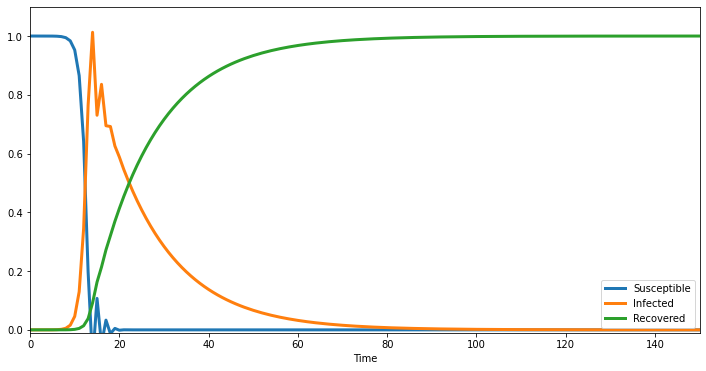

In [7]:
beta = 2 # number of individuals infected by a single person
gamma = 0.07 # rate of recovery (reciprocal of the average duration of the disease in days)
N = 1

# Initial Values

R = [0] # number of recovered individuals
I = [1.e-6] # number of infected individuals
S = [N - I[0] - R[0]] # number of susceptible individuals

def change(S, I, R):
    s = -beta * I * S/N
    i = beta * I * S/N - gamma * I
    r = gamma * I
    return s, i, r

T = 365
dt = 1
times = np.linspace(0, T, int(T/dt) + 1)

for t in times[1:]:
    # Using Euler's method for now
    s, i, r = change(S[-1], I[-1], R[-1])
    S.append(S[-1] + dt*s)
    I.append(I[-1] + dt*i)
    R.append(R[-1] + dt*r)

plt.figure(figsize=(12, 6))
plt.plot(times, S, lw=3)
plt.plot(times, I, lw=3)
plt.plot(times, R, lw=3)
plt.legend(['Susceptible', 'Infected', 'Recovered'])
plt.xlabel('Time')
plt.xlim(0, 150)
plt.ylim(-0.01, 1.1)

# Functions

In [34]:
def extract_region_data(data, region):
    days = data.keys()[4:]
    tophalf = data.iloc[:]
    rows = tophalf['Country/Region'].isin([region])
    region_data = [tophalf[day][rows].sum() for day in days]
    return region_data

def exponential_beta_fit(cases, start, n=14):
    dd = np.arange(start + n)
    def resid(beta):
        prediction = cases[start] * np.exp(beta * (dd-start))
        return prediction[start:start+n] - cases[start:start+n]
    
    soln = optimize.least_squares(resid, 0.2)
    beta = soln.x[0]
    return beta

def plot_fit(cases, beta, start, n=14):
    length = start + n
    dd = np.arange(length)
    plt.plot(cases[:length])
    prediction = cases[start] * np.exp(beta * (dd-start))
    plt.plot(dd[start:length], prediction[start:length], '--k')
    plt.legend(['Data', r'fit with $\beta$={:.3f}'.format(beta)])
    plt.xlabel('Days')
    plt.ylabel('Total Cases')